# 1. 클래스 별 폴더 만들기

모든 클래스가 하나의 폴더에 들어있고, **labels.csv**에 각 파일의 클래스 정보가 있다. 따라서 이를 이용하여 클래스 별 폴더로 나누겠다. 

## 1.1. pandas를 사용하여 csv파일 읽기

In [1]:
import pandas as pd
labels = pd.read_csv("./labels.csv")

## 1.2. 각 클래스 별 폴더 만들기

dataset 폴더를 만들고, 하위 폴더에 각 클래스를 저장하겠다.

In [2]:
import os

os.makedirs("./dataset", exist_ok=True)

for class_name in labels['breed'].unique():
    os.makedirs("./dataset/"+class_name, exist_ok=True)  # exist_ok가 True이면 디렉토리가 이미 있는 경우는 넘어가고, 없으면 만든다.

## 1.3. 모든 이미지 파일은 jpg 임을 확인

In [3]:
for file_name in os.listdir("./train"):
    if file_name.split('.')[-1] != 'jpg':
        print(file_name)

## 1.4. labels.csv에 기반하여 파일을 폴더 별로 분류

In [4]:
import shutil

for idx, row in labels.iterrows():
    file_name = row['id']
    class_name = row['breed']
    shutil.copy("./train/"+file_name+".jpg", "./dataset/"+class_name+'/'+file_name+".jpg")

## 1.5. 데이터 크리에이터 캠프에서 만든 draw_class_barplot 함수로 클래스 별 데이터 수 확인

전체 데이터 수: 10222


<Figure size 10000x10000 with 0 Axes>

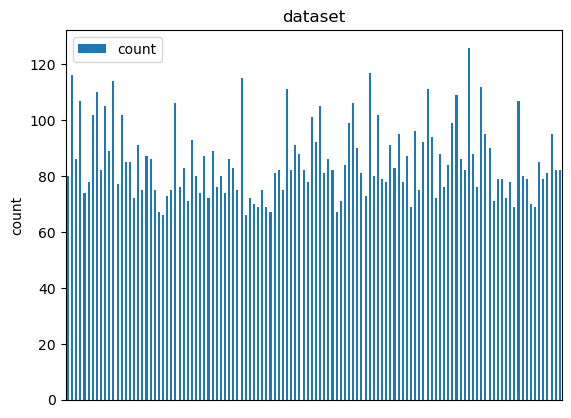

In [5]:
import matplotlib.pyplot as plt

def draw_class_barplot(
    path: str,
    title: str):
    
    dir_list = os.listdir(path)

    classLenLst = []
    for class_name in dir_list:
        classLenLst.append(len(os.listdir(path+class_name)))
        
    df_dict = dict()
    df_dict["name"] = dir_list
    df_dict["count"] = classLenLst

    df= pd.DataFrame(df_dict)

    plt.figure(figsize=(100,100))
    df.plot(kind="bar", x='name', y='count')
    plt.xlabel("class name")
    plt.ylabel("count")
    plt.title(title)
    ax = plt.gca()

    #hide x-axis
    ax.get_xaxis().set_visible(False)

    return df

df = draw_class_barplot("./dataset/", "dataset")
print(f"전체 데이터 수: {df['count'].sum(0)}")

# 2. train, test 데이터 나누기

## 2.1. train_dataset, test_dataset 폴더 만들기

In [6]:
os.makedirs("./train_dataset", exist_ok=True)
os.makedirs("./test_dataset", exist_ok=True)

for class_name in labels['breed'].unique():
    os.makedirs("./train_dataset/"+class_name, exist_ok=True)  # exist_ok가 True이면 디렉토리가 이미 있는 경우는 넘어가고, 없으면 만든다.
    os.makedirs("./test_dataset/"+class_name, exist_ok=True)

## 2.2. 데이터의 80%를 학습 20%를 test로 사용

각 클래스 별로 20%의 데이터를 test 데이터로 사용

In [7]:
TRAIN_PCT = 0.8

In [8]:
class_lst = os.listdir("./dataset")

for label_name in class_lst:
    file_lst = os.listdir("./dataset/"+label_name)
    for file_name in file_lst[:round(len(file_lst)*TRAIN_PCT)]:
        shutil.copy("./dataset/"+label_name+'/'+file_name, "./train_dataset/"+label_name+'/'+file_name)
        
    for file_name in file_lst[round(len(file_lst)*TRAIN_PCT):]:
        shutil.copy("./dataset/"+label_name+'/'+file_name, "./test_dataset/"+label_name+'/'+file_name)

## 2.3. 나눠진 데이터를 확인

전체 train 데이터 수: 8185
전체 test 데이터 수: 2037


<Figure size 10000x10000 with 0 Axes>

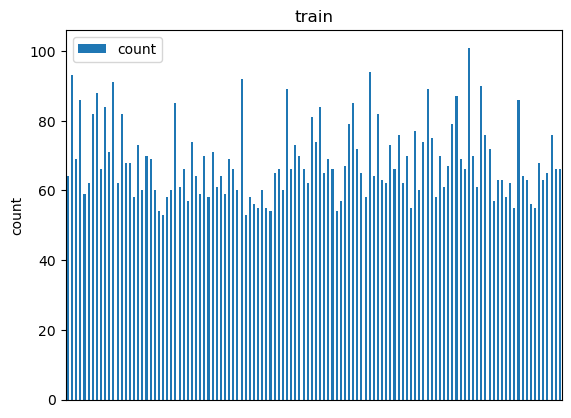

<Figure size 10000x10000 with 0 Axes>

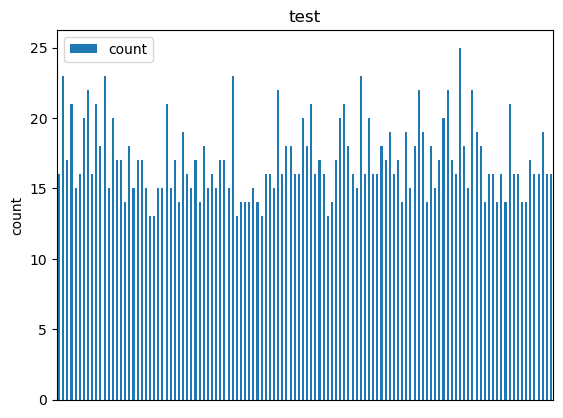

In [9]:
df = draw_class_barplot("./train_dataset/", "train")
print(f"전체 train 데이터 수: {df['count'].sum(0)}")
df = draw_class_barplot("./test_dataset/", "test")
print(f"전체 test 데이터 수: {df['count'].sum(0)}")

# 3. PyTorch 학습 코드 작성

## 3.1. 이미지 전처리 리스트 작성

torchvision의 transoform을 사용하여 전처리 리스트를 작성한다.

In [10]:
import torchvision.transforms as transforms

transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),  # ToTensor는 0 ~ 255로 이루어진 정수를 0 ~ 1의 실수로 바꿔준다.
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

## 3.2. ImageFolder 메소드를 사용하여 dataloader 생성

In [11]:
# 파라미터 설정
BATCH_SIZE = 64
NUM_WORKERS = 0  # 이 값은 사용하는 쓰레드를 의미하므로 적절히 설정하자 (0는 main thread 사용을 의미한다)

In [12]:
import torch
import torchvision

train_dataset = torchvision.datasets.ImageFolder(
    root="./train_dataset",
    transform=transformer)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

## 3.3. 모델 만들기

In [13]:
# Pretrained model 불러오기
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.nn.functional as F

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)  # Pretrained resnet18 불러오기

# Freeze All Layers
for p in model.parameters():
    p.requires_grad = False

num_features = model.fc.in_features  # Convolutional Layer로 얻어지는 feature 가져오기
model.fc = nn.Linear(num_features, 120)  # 120개의 클래스를 구분할 수 있도록 마지막 fully connected layer 수정하기

'''
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 120)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Model()
'''

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Jaehyun/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

'\nclass Model(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.conv1 = nn.Conv2d(3, 6, 5)\n        self.pool = nn.MaxPool2d(2, 2)\n        self.conv2 = nn.Conv2d(6, 16, 5)\n        self.fc1 = nn.Linear(16 * 5 * 5, 120)\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, 120)\n\n    def forward(self, x):\n        x = self.pool(F.relu(self.conv1(x)))\n        x = self.pool(F.relu(self.conv2(x)))\n        x = torch.flatten(x, 1)  # flatten all dimensions except batch\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x\n    \nmodel = Model()\n'

## 3.4. loss function, optimizer 정의

In [14]:
from torch import optim

learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 3.5. 테스트 함수 작성

In [15]:
# test_dataloader를 정의
test_dataset = torchvision.datasets.ImageFolder(
    root="./test_dataset",
    transform=transformer)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

# 테스트 함수
def test():
    model.eval()  # model을 evaluation 하기 위한 상태로 바꾼다.

    test_loss = 0
    total = 0
    correct = 0

    for data in test_dataloader:
        inputs = data[0]
        labels = data[1]

        outputs = model(inputs)
        outputs = F.softmax(outputs, dim=0)  # 확률 값으로 변경

        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        test_loss += loss.item()

    test_loss = test_loss / len(test_dataloader)

    accuracy = 100 * correct // total

    print(f"test loss: {test_loss}")
    print(f"test accuracy: {accuracy}%")

## 3.5. 학습

In [16]:
EPOCH = 2
model.train()  # 모델을 학습하기 위한 상태로 변경

for epoch in range(EPOCH):
    train_loss = 0
    total = 0
    correct = 0
    
    for i, data in enumerate(train_dataloader):
        
        inputs = data[0]
        labels = data[1]
        
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = F.softmax(outputs, dim=0)  # 확률 값으로 변경
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        train_loss += loss.item()
        
    train_loss = train_loss / len(train_dataloader)
    accuracy = 100 * correct // total
    
    print(f"train loss at epoch {epoch+1}: {train_loss}")
    print(f"train accuracy: {accuracy}%")
    
    test()

train loss at epoch 1: 4.783060614019632
train accuracy: 16%
test loss: 4.7778093963861465
test accuracy: 39%
train loss at epoch 2: 4.768966395407915
train accuracy: 58%
test loss: 4.760245144367218
test accuracy: 62%


# 4. 제출

submission 파일을 만들어 kaggle에 올려본다.

## 4.1. 만들어진 모델로 Prediction DataFrame 만들기

In [20]:
from torchvision.io import read_image

test_path = "./test/"
for file_name in os.listdir(test_path):
    img = read_image(test_path + file_name)
    print(type(img))
    print(img.shape)
    break

<class 'torch.Tensor'>
torch.Size([3, 449, 600])
